## Imports

In [4]:
import torch
import torchtext
import pytorch_lightning as pl
import os

from data import TEXT, LABEL, test_data
import models

## Loading a model

In [5]:
MODEL = None

# Load a model from checkpoint and use it for inference
def load_model(encoder, version = None):
    # If no version specified, use the latest model
    if version is None:
        versions = [int(f[8:-5]) for f in os.listdir(f"checkpoints/{encoder}")]
        version = versions[-1]

    model_path = f"checkpoints/{encoder}/version_{version}.ckpt"
    print("Using " + model_path)
    global MODEL
    MODEL = models.Classifier.load_from_checkpoint(model_path).eval()

load_model("pooledbilstm", 2) # pooledbilstm/version_2.ckpt uses embedding_dim = 4096

Using checkpoints/pooledbilstm/version_2.ckpt


# Results

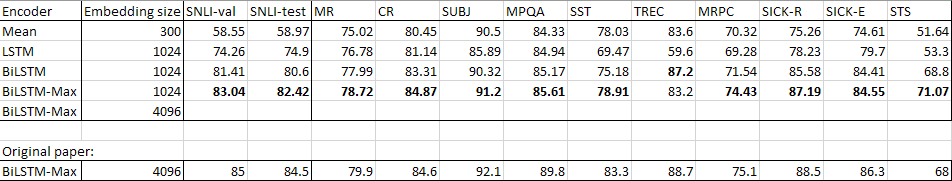

# Interactive Inference

In [6]:
# Print batch of token indices as text
def print_text(tokens):
    if len(tokens.shape) == 1: tokens = [tokens]
    for s in tokens:
        print(" ".join([TEXT.vocab.itos[t] if t > 1 else '' for t in s]))

# Make entailment prediction from premise and hypothesis
def predict(premise, hypothesis):
    print(f"\x1b[0m\"{premise}\" -> \"{hypothesis}\":")
    premise = TEXT.process([TEXT.preprocess(premise)])
    hypothesis = TEXT.process([TEXT.preprocess(hypothesis)])
    MODEL.eval()
    preds = MODEL(premise, hypothesis).softmax(1)
    pred = preds.argmax()

    color = '\x1b[0m'
    if pred == 0: color = '\x1b[1;32m' # entailment
    elif pred == 1: color = '\x1b[1;31m' # contradiction
    elif pred == 2: color = '\x1b[1;33m' # neutral

    print(f"    {color}{LABEL.vocab.itos[pred]} ({preds[0, pred] * 100:.2f}%)\n")

In [7]:
predict("Alice is going for a walk.", "Alice is cleaning her room.")
predict("Alice is going for a walk.", "Alice is wearing a hat.")
predict("Alice is going for a walk.", "Alice is outside.")

"Alice is going for a walk." -> "Alice is cleaning her room.":
    contradiction (99.54%)

"Alice is going for a walk." -> "Alice is wearing a hat.":
    neutral (97.82%)

"Alice is going for a walk." -> "Alice is outside.":
    entailment (80.23%)



# Analysis

## What does the model encode?

In [50]:
import sklearn
import numpy as np

def encode(sentence):
    sentence = TEXT.process([TEXT.preprocess(sentence)])
    return MODEL.encoder(sentence).detach().squeeze()

def cosine_similarity(a, b):
    return (a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))).item()

#### The similarity of sentence representations does not give clear insight into entailment / contradiction:

In [93]:
print(cosine_similarity(encode("Alice is going for a walk in the park."), encode("Alice is going for a walk.")))
print(cosine_similarity(encode("Alice is going for a walk in the park."), encode("Alice is not going for a walk in the park.")))

0.8183154463768005
0.9071491360664368


In [92]:
print(cosine_similarity(encode("Alice and Bob are friends."), encode("Alice and Bob are pals.")))
print(cosine_similarity(encode("Alice and Bob are friends."), encode("Cindy and Tom are friends.")))

0.8848890662193298
0.8844414949417114


#### The sentence embedding changes significantly if the closing period is omitted, even though the meaning should be the same. This might have to do with the dataset containing both full sentences and sentence fragments.

In [97]:
print(cosine_similarity(encode("The couple danced."), encode("The couple danced")))

0.8698563575744629


## What is difficult for the model?

In [8]:
from tqdm import tqdm

# Get predictions for each item in test set
percentages = []
for e in tqdm(test_data):
    premise = TEXT.process([e.premise])
    hypothesis = TEXT.process([e.hypothesis])
    label = LABEL.process([e.label]).squeeze()
    preds = MODEL(premise, hypothesis).softmax(1).squeeze()
    percentages.append(preds[label].item())

# Sort datapoints by how correct the model was
difficulty_ranking = sorted(range(len(percentages)), key=lambda k: percentages[k])

100%|██████████████████████████████████████████████████████████████████████████████| 9824/9824 [24:00<00:00,  6.82it/s]


#### The examples the model is most sure about are all contradictions. It seems to biased towards them.

In [11]:
# Easiest examples
for i in list(reversed(difficulty_ranking))[:10]:
    premise = TEXT.process([test_data[i].premise])
    hypothesis = TEXT.process([test_data[i].hypothesis])
    label = LABEL.process([test_data[i].label]).squeeze()
    preds = MODEL(premise, hypothesis).softmax(1).squeeze()
    pred = preds.argmax()
    print_text(premise)
    print_text(hypothesis)
    print(f"Correct: {test_data[i].label}")
    print(f"Prediction: {LABEL.vocab.itos[pred]} ({preds[pred] * 100:.2f}%)\n")

A brown dog and a black and white dog are running over grassy hills .
one cat sleeps
Correct: contradiction
Prediction: contradiction (100.00%)

A child dressed in purple clothing and a hat runs in splashing water while a man and a small boy walk nearby .
a cat sleeps on the couch
Correct: contradiction
Prediction: contradiction (100.00%)

A dog standing near snow looking at water .
A cat is laying on the couch .
Correct: contradiction
Prediction: contradiction (100.00%)

Woman running in a park while listening to music .
A man cooking at home .
Correct: contradiction
Prediction: contradiction (100.00%)

A group of men are riding a moving walkway .
A group of women are baking in a kitchen .
Correct: contradiction
Prediction: contradiction (100.00%)

A furry dog is jumping over a hurdle .
A cat sleeps in the window .
Correct: contradiction
Prediction: contradiction (100.00%)

The man in white is playing basketball against the man in blue .
A woman wearing red plays hockey .
Correct: con

#### As far as points of failure are concerned, there is more variety:

In [12]:
# Most difficult examples
for i in difficulty_ranking[:10]:
    premise = TEXT.process([test_data[i].premise])
    hypothesis = TEXT.process([test_data[i].hypothesis])
    label = LABEL.process([test_data[i].label]).squeeze()
    preds = MODEL(premise, hypothesis).softmax(1).squeeze()
    pred = preds.argmax()
    print_text(premise)
    print_text(hypothesis)
    print(f"Correct: {test_data[i].label}")
    print(f"Prediction: {LABEL.vocab.itos[pred]} ({preds[pred] * 100:.2f}%)\n")

Several women are playing volleyball .
This does n't look like soccer
Correct: entailment
Prediction: contradiction (99.94%)

two women in lingerie with green feathers around waist
Two women do n't wear much clothing .
Correct: entailment
Prediction: contradiction (99.34%)

An older gentleman looks at the camera while he is building a deck .
An older gentleman in overalls looks at the camera while he is building a stained red deck in front of a house .
Correct: entailment
Prediction: neutral (97.57%)

A young girl running on grass
The girl is not standing still .
Correct: entailment
Prediction: contradiction (98.09%)

In a small village a Man sets sail along the  .
A man hunting crocodiles
Correct: neutral
Prediction: contradiction (99.87%)

Three children in a black dog kennel .
There are dogs in the kennel .
Correct: contradiction
Prediction: entailment (97.56%)

A performer plays an instrument for the audience .
The instrument plays a performer for an audience .
Correct: contradicti

#### The model seems to struggle with negation:

In [85]:
predict("A young girl running on grass", "The girl is not standing still.")
predict("A young girl running on grass", "The girl is standing still.")

"A young girl running on grass" -> "The girl is not standing still.":
    contradiction (98.09%)

"A young girl running on grass" -> "The girl is standing still.":
    contradiction (99.86%)



#### Puncuation affects the result much more than it should:

In [89]:
predict("A young girl is running", "The girl is not standing still.")
predict("A young girl is running.", "The girl is not standing still.")

"A young girl is running" -> "The girl is not standing still.":
    contradiction (98.33%)

"A young girl is running." -> "The girl is not standing still.":
    entailment (47.66%)



#### It also gets confused by two-way relationships:

In [83]:
predict("A performer plays an instrument for the audience.", "The instrument plays a performer for an audience.")
predict("Alice is standing next to Bob.", "Bob is standing next to Alice.")

"A performer plays an instrument for the audience." -> "The instrument plays a performer for an audience.":
    entailment (98.00%)

"Alice is standing next to Bob." -> "Bob is standing next to Alice.":
    contradiction (63.67%)

